In [6]:
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data


def grid_pnt_str_to_list( grid_pnt_str ):
    return grid_pnt_str.replace('(','').replace(')','').replace(' ','').split(',')

def get_2d_grid_dict( grid_dict, z_plane ):
    grid_dict_2D = {}
    
    for grid1_pnt_str in grid_dict.keys():
        # Convert the string-key into coordinate pair
        grid1_pnt_coors = grid_pnt_str_to_list( grid1_pnt_str )
        # Ignore if not on proper z plane
        if int(grid1_pnt_coors[2])!=z_plane:
            continue
        grid1_pnt_coors_2D = [int(grid1_pnt_coors[0]), \
                                int(grid1_pnt_coors[1])]
        
        # Add the grid point coordinates to the list of original grid point coordinates
        grid2_pnt_coors = grid_dict[grid1_pnt_str]
        grid2_pnt_coors_2D = [int(grid2_pnt_coors[0]), \
                                int(grid2_pnt_coors[1])]
        
        grid_dict_2D[str(tuple(grid1_pnt_coors_2D))] = tuple(grid2_pnt_coors_2D)
    return grid_dict_2D

def get_grid_lists_from_dict( grid_dict ):
    grid1_all_coordinates = []
    grid2_all_coordinates = []
    
    for grid1_pnt_str in grid_dict.keys():
        grid1_coors = []
        # Convert the string-key into coordinate pair
        grid1_pnt_coors = grid_pnt_str_to_list( grid1_pnt_str )
        # Add coordinates into list of float coordinates
        for grid1_pnt_coor in grid1_pnt_coors:
            grid1_coors.append(float(grid1_pnt_coor))
            
        grid1_all_coordinates.append( grid1_coors )
        grid2_all_coordinates.append( list(grid_dict[grid1_pnt_str]) )
    return np.array(grid1_all_coordinates), np.array(grid2_all_coordinates)

def my_round( x, base=5 ):
    return int( base * round(float(x)/base))

In [23]:
map(int, (1.1,2.9))

[1, 2]

In [22]:
int((1.1,2.9))

TypeError: int() argument must be a string or a number, not 'tuple'

In [237]:
import time

import neuroglancer
import numpy as np
            
class GridLayer():
    def __init__(self, viewer, shape=(800, 600, 500),  vox_size=(10000, 10000, 10000)):
        self.vox_size = vox_size
        self.shape = shape
        self.jump_x = 150
        self.jump_y = 150
        self.jump_z = 200
        self.viewer = viewer
        self.grid_dict = {}
        self.grid_dict_abs = {}
        self.triangle_index_to_grid_pts = {}

    def get_grid_layer(self):
        grid_layer = neuroglancer.AnnotationLayer(voxel_size=self.vox_size)
        # grid_array = np.empty(self.shape, dtype=object)

        point_list = []

        for i in range(0, self.shape[0], self.jump_x):
            for j in range(0, self.shape[1], self.jump_y):
                for k in range(0, self.shape[2], self.jump_z):
                    self.grid_dict[repr((i, j, k))] = (i, j, k)
                    point_list.append((i, j, k))

        grid_layer.annotations = [neuroglancer.PointAnnotation(id=repr(pos), point=pos) for pos in point_list]

        return grid_layer
    
    def update_grid_dict(self):
        """
        Loads the current locations of every gridpoint and saves in the grid_dict format
        """
        with self.viewer.txn() as s:
            ss = s.layers['points']
            grid_as_json = ss.to_json()
            grid_list = grid_as_json['annotations']

        for gridpnt in grid_list:
            original_pos = gridpnt['id']
            curr_pos = gridpnt['point']
            integer_coordinates = map(int, curr_pos)
            integer_coordinates[2] = my_round( integer_coordinates[2], self.jump_z)
            self.grid_dict[original_pos] = tuple(integer_coordinates)
            
            # Update grid_dict_abs
            abs_grid1_pos_tuple = list(original_pos.replace('(','').replace(')','').replace(' ','').split(','))
            abs_grid1_pos_tuple = map(float, abs_grid1_pos_tuple)
            
            abs_grid1_pos_tuple[0] = int(abs_grid1_pos_tuple[0]*self.jump_x)
            abs_grid1_pos_tuple[1] = int(abs_grid1_pos_tuple[1]*self.jump_y)
            abs_grid1_pos_tuple[2] = int(abs_grid1_pos_tuple[2]*self.jump_z)
            
            float_grid2_coordinates = map(float, curr_pos)
            abs_grid2_pos_tuple = ( int(float_grid2_coordinates[0]*self.jump_x),
                                    int(float_grid2_coordinates[1]*self.jump_y),
                                    int(float_grid2_coordinates[2]*self.jump_z))
            self.grid_dict_abs[str(tuple(abs_grid1_pos_tuple))] = abs_grid2_pos_tuple

    def print_coordiante(self):
        if 'selectedAnnotation' in self.viewer.state.layers._layers[2]._json_data:
            print(self.grid_dict[self.viewer.state.layers._layers[2]._json_data['selectedAnnotation']])
            
    
    
class InteractiveInference(object):
    def __init__(self, cube):

        viewer = self.viewer = neuroglancer.Viewer()
        viewer.actions.add('move_left', self.move_cube_left)
        viewer.actions.add('move_down', self.move_cube_down)
        viewer.actions.add('move_right', self.move_cube_right)
        viewer.actions.add('move_up', self.move_cube_up)
        viewer.actions.add('morph_volume', self.morph_volume_layer)
        viewer.actions.add('reset_cube', self.reset_cube_volume)
        viewer.actions.add('reset_grid', self.reset_grid_points)

        self.cube = cube
        self.off_x = 0
        self.off_y = 0
        self.off_z = 0
        self.grid_layer = GridLayer(self.viewer)
        self.cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000], voxel_offset=[self.off_x, self.off_y, self.off_z])

        with viewer.config_state.txn() as s:
            s.input_event_bindings.data_view['shift+keyw'] = 'move_up'
            s.input_event_bindings.data_view['shift+keys'] = 'move_down'
            s.input_event_bindings.data_view['shift+keya'] = 'move_left'
            s.input_event_bindings.data_view['shift+keyd'] = 'move_right'
            s.input_event_bindings.data_view['shift+keyp'] = 'morph_volume'
            s.input_event_bindings.data_view['shift+keyr'] = 'reset_cube'
            s.input_event_bindings.data_view['shift+keyg'] = 'reset_grid'

        with viewer.txn() as s:
            s.layers['image'] = neuroglancer.ImageLayer(
                source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
            # Resets X/Y/Z plane orientation
            s.navigation.pose.orientation = [0,0,0,1]
            # Zooms out 
        #     s.navigation.zoomFactor = 10000 # If 4panel
            s.navigation.zoomFactor = 4000 # If xy

            # Resets 3D Viewer Orientation
            s.perspectiveOrientation = [0,0,0,1]
            # Zooms out
            s.perspectiveZoom = 75000
            
            s.layers['cube'] = neuroglancer.ImageLayer(source=self.cube_volm)
            s.layers['points'] = self.grid_layer.get_grid_layer()
            # s.layers['points'] = neuroglancer.AnnotationLayer(voxel_size=[100000, 100000, 100000])\
            
    def reset_grid_points(self, action_state):
        with viewer.txn() as s:
            s.layers['points'] = self.grid_layer.get_grid_layer()
    
    def reset_cube_volume(self, action_state):
        self.off_x = 0
        self.off_y = 0
        self.off_z = 0
        self.cube = get_cube_test_volume()
        self.cube_volm = neuroglancer.LocalVolume(data=self.cube, 
                                                  voxel_size=[10000, 10000, 10000], 
                                                  voxel_offset=[self.off_x, self.off_y, self.off_z])
        with viewer.txn() as s:
            s.layers['cube'] = neuroglancer.ImageLayer(source=self.cube_volm)

    def move_cube_left(self, action_state):

        self.off_x -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_right(self, action_state):
        self.off_x += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_up(self, action_state):
        self.off_y -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_down(self, action_state):
        self.off_y += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer
            
#     def morph_volume_layer_OLD(self, action_state):
#         self.grid_layer.update_grid_dict()
#         grid_map = self.grid_layer.grid_dict # Gets grid_dict
    
#         self.cube = update_volume( grid_map, self.cube )
#         cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
#                                              voxel_offset=[self.off_x, self.off_y, self.off_z])
#         cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
#         with self.viewer.txn() as s:
#             s.layers['cube'] = cube_layer
            
    def morph_volume_layer(self, action_state):
        self.grid_layer.update_grid_dict()
        grid_map = self.grid_layer.grid_dict # Gets grid_dict
        grid_map_abs = self.grid_layer.grid_dict_abs
    
        self.cube = update_volume( grid_map, self.cube.copy() )
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer
            
def update_volume( grid_map, volume ):
    volume_shape = np.shape( volume )
    new_volume = volume.copy()
    
#     for z in range(volume_shape[2]):
    for z in range(100):
        try:
            grid_dict_2D = get_2d_grid_dict( grid_map, 0 )
            grid_dict_2D_grid2, grid_dict_2D_grid1 = get_grid_lists_from_dict( grid_dict_2D )

            tform = PiecewiseAffineTransform()
            tform.estimate( grid_dict_2D_grid1 , grid_dict_2D_grid2 )

            image = volume[z,:,:]*255
            rows, cols = image.shape[0], image.shape[1]
            out_rows, out_cols = rows, cols
            warped_img = warp(image, tform, output_shape=(out_rows, out_cols))

            new_volume[z,:,:] = warped_img
        except IndexError:
            pass
#         except Exception as e:
#             print(e)
    return new_volume

In [238]:
def get_cube_test_volume(cube_len=100):
    cube = np.zeros((cube_len, cube_len, cube_len), dtype=np.uint8)

    cube[:, :, :10] = 1
    cube[:, :, cube_len-10:cube_len] = 1

    cube[:10, :, :] = 1
    cube[cube_len-10:cube_len, :, :] = 1

    cube[:, :10, :] = 1
    cube[:, cube_len-10:cube_len, :] = 1
    
    return cube

cube = get_cube_test_volume()

neuroglancer.set_server_bind_address(bind_address='0.0.0.0', bind_port=35000)

inf = InteractiveInference(cube)
viewer = inf.viewer
ip_name = 'ec2-52-53-248-156.us-west-1.compute.amazonaws.com'  ## Change for different machine
ip_name = '132.239.73.85'  ## Change for different machine

print('http://' + ip_name + ':' + viewer.get_viewer_url().split(':')[2])

http://132.239.73.85:35000/v/a4daea00bbe3d7ce045264661bef088f567d3bb1/


In [208]:
gd = inf.grid_layer.grid_dict

cube = get_cube_test_volume( 100 )

new_cube = update_volume( gd, cube.copy() )

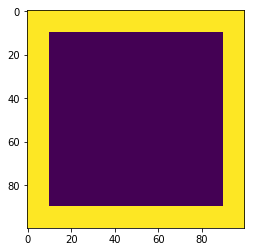

In [209]:
plt.imshow(cube[:,:,10], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

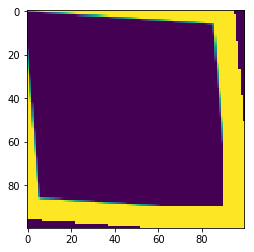

In [220]:
image = cube[:,:,10]*255

grid_dict_2D = get_2d_grid_dict( gd, 0 )
grid_dict_2D_grid2, grid_dict_2D_grid1 = get_grid_lists_from_dict( grid_dict_2D )

tform = PiecewiseAffineTransform()
tform.estimate( grid_dict_2D_grid1 , grid_dict_2D_grid2 )

# image = volume[:,:,z]
rows, cols = image.shape[0], image.shape[1]
out_rows, out_cols = rows, cols
warped_img = warp(image, tform, output_shape=(out_rows, out_cols))

# volume[:,:,z] = warped_img
plt.imshow(warped_img, norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

In [175]:
grid_dict_2D_grid2

array([[600, 450],
       [450, 300],
       [750, 300],
       [450, 150],
       [150, 450],
       [150, 150],
       [600, 300],
       [450,   0],
       [300, 300],
       [  0, 300],
       [450, 450],
       [600, 150],
       [750, 150],
       [ 11,  12],
       [150, 300],
       [300, 150],
       [600,   0],
       [143,  22],
       [  0, 450],
       [750,   0],
       [300,   0],
       [  0, 150],
       [300, 450],
       [750, 450]])

In [174]:
grid_dict_2D_grid1

array([[600., 450.],
       [450., 300.],
       [750., 300.],
       [450., 150.],
       [150., 450.],
       [150., 150.],
       [600., 300.],
       [450.,   0.],
       [300., 300.],
       [  0., 300.],
       [450., 450.],
       [600., 150.],
       [750., 150.],
       [  0.,   0.],
       [150., 300.],
       [300., 150.],
       [600.,   0.],
       [150.,   0.],
       [  0., 450.],
       [750.,   0.],
       [300.,   0.],
       [  0., 150.],
       [300., 450.],
       [750., 450.]])

In [173]:
(grid_dict_2D_grid1==grid_dict_2D_grid2).all()

False

In [93]:
warped_img[1,76]

0.0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

In [88]:
warped_img[50,1]

0.0

In [80]:
np.amax(warped_img)

0.00392156862745098

In [81]:
1./.00392156862745098

255.0

[[0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 

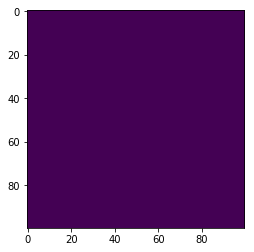

In [73]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

gd = inf.grid_layer.grid_dict

new_cube = update_volume( gd, cube.copy() )

plt.imshow(new_cube[:,:,10], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

In [98]:
inf.grid_layer.grid_dict

{'(0, 0, 0)': (25, 27, 0),
 '(0, 0, 200)': (0, 0, 200),
 '(0, 0, 400)': (0, 0, 400),
 '(0, 150, 0)': (0, 150, 0),
 '(0, 150, 200)': (0, 150, 200),
 '(0, 150, 400)': (0, 150, 400),
 '(0, 300, 0)': (0, 300, 0),
 '(0, 300, 200)': (0, 300, 200),
 '(0, 300, 400)': (0, 300, 400),
 '(0, 450, 0)': (0, 450, 0),
 '(0, 450, 200)': (0, 450, 200),
 '(0, 450, 400)': (0, 450, 400),
 '(150, 0, 0)': (150, 0, 0),
 '(150, 0, 200)': (150, 0, 200),
 '(150, 0, 400)': (150, 0, 400),
 '(150, 150, 0)': (150, 150, 0),
 '(150, 150, 200)': (150, 150, 200),
 '(150, 150, 400)': (150, 150, 400),
 '(150, 300, 0)': (150, 300, 0),
 '(150, 300, 200)': (150, 300, 200),
 '(150, 300, 400)': (150, 300, 400),
 '(150, 450, 0)': (150, 450, 0),
 '(150, 450, 200)': (150, 450, 200),
 '(150, 450, 400)': (150, 450, 400),
 '(300, 0, 0)': (300, 0, 0),
 '(300, 0, 200)': (300, 0, 200),
 '(300, 0, 400)': (300, 0, 400),
 '(300, 150, 0)': (300, 150, 0),
 '(300, 150, 200)': (300, 150, 200),
 '(300, 150, 400)': (300, 150, 400),
 '(300, 300,

In [43]:
inf.grid_layer.grid_dict

{'(0, 0, 0)': (16.3847713470459, 6.646653175354004, -7.223887266150086e-09),
 '(0, 0, 20)': (0, 0, 20),
 '(0, 0, 40)': (0, 0, 40),
 '(0, 50, 0)': (0, 50, 0),
 '(0, 50, 20)': (0, 50, 20),
 '(0, 50, 40)': (0, 50, 40),
 '(50, 0, 0)': (50, 0, 0),
 '(50, 0, 20)': (50, 0, 20),
 '(50, 0, 40)': (50, 0, 40),
 '(50, 50, 0)': (50, 50, 0),
 '(50, 50, 20)': (50, 50, 20),
 '(50, 50, 40)': (50, 50, 40)}

In [6]:
grid_dict = {}
with inf.viewer.txn() as s:
    ss = s.layers['points']
    grid_as_json = ss.to_json()
    grid_list = grid_as_json['annotations']
    
for gridpnt in grid_list:
    original_pos = gridpnt['id']
    curr_pos = gridpnt['point']
    grid_dict[original_pos] = curr_pos

In [9]:
type((1,2))

tuple

In [10]:
tuple(curr_pos)

(50, 50, 40)

In [61]:
dir(ss)

['__class__',
 '__deepcopy__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattr__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_cached_wrappers',
 '_get_wrapped',
 '_json_data',
 '_lock',
 '_readonly',
 '_set_wrapped',
 'layer',
 'name',
 'supports_readonly',
 'to_json',
 'visible']